# VGG-11

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms, datasets
from sklearn.metrics import precision_recall_fscore_support
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchinfo
import time
from torchmetrics.classification import MulticlassROC
from sklearn.metrics import confusion_matrix

In [49]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

batch_size = 16

# Load the dataset
dataset = datasets.ImageFolder(root='./cnn_dataset/', transform=transform)

# Dataset split into training, validation and testing set
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Dataloaders
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [50]:
# Check image channel if 1, grayscale image if 3, RGB image
for image,label in trainloader:
    print(image.shape[1])
    break

1


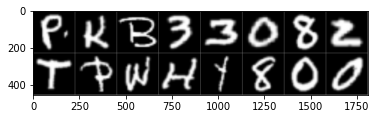

P     K     B     3     3     O     8     Z     T     P     W     H     Y     8     0     O    


In [51]:
classes = dataset.classes
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [52]:
class VGG11(nn.Module):
    def __init__(self):
        super().__init__()
        self.convlayers = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fclayers = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(4096, 36)
        )

    def forward(self, x):
        x = self.convlayers(x)
        x = x.view(x.size(0), -1)
        x = self.fclayers(x)
        return x

In [53]:
modelVGG = VGG11()
print(modelVGG)

VGG11(
  (convlayers): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU()
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (16): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding

In [54]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelVGG.parameters(), lr=0.001)

## Model Training

In [ ]:
# Start time
startTime = time.time()

training_loss_plt_arr = []
validation_loss_plt_arr = []
testing_loss_plt_arr = []

epochs = 2
# Epoch Iteration
for epoch in range(epochs):
    training_loss = 0.0
    
    #Training loop
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = modelVGG(inputs)
        loss_training = criterion(outputs, labels)
        loss_training.backward()
        optimizer.step()

        training_loss += loss_training.item()
        if i % 2000 == 1999:
            
            # Validation loop
            validation_loss = 0.0
            with torch.no_grad():
                for data in valloader:
                    images, labels = data
                    outputs = modelVGG(images)
                    loss_validation = criterion(outputs, labels)
                    validation_loss += loss_validation.item()
            
            # Testing loop
            testing_loss = 0.0
            with torch.no_grad():
                for data in testloader:
                    images, labels = data
                    outputs = modelVGG(images)
                    loss_testing = criterion(outputs, labels)
                    testing_loss += loss_testing.item()

            print(f"[{epoch + 1}, {i + 1}], Training loss: {training_loss / 2000:.3f}, Validation loss: {validation_loss / len(valloader):.3f}, Testing loss: {testing_loss / len(testloader):.3f}")
            training_loss_plt_arr.append(round((training_loss / 2000),3))
            validation_loss_plt_arr.append(round((validation_loss / len(valloader)),3))
            testing_loss_plt_arr.append(round((testing_loss / len(testloader)),3))
            training_loss = 0.0

print("Finished Training")
    
# End time
endTime = time.time()
time_to_train = (endTime - startTime)
print(f"\nTime to train = {time_to_train:.2f}\n")

In [ ]:
# Normalize Losses for better visualisation
def normalizedLossesPlot():
    training_loss_plt_arr_max = max(training_loss_plt_arr)
    training_loss_plt_arr_min = min(training_loss_plt_arr)
    validation_loss_plt_arr_max = max(validation_loss_plt_arr)
    validation_loss_plt_arr_min = min(validation_loss_plt_arr)
    testing_loss_plt_arr_max = max(testing_loss_plt_arr)
    testing_loss_plt_arr_min = min(testing_loss_plt_arr)

    training_loss_minmax_deno = training_loss_plt_arr_max - training_loss_plt_arr_min
    validation_loss_minmax_deno = validation_loss_plt_arr_max - validation_loss_plt_arr_min
    testing_loss_minmax_deno = testing_loss_plt_arr_max - testing_loss_plt_arr_min

    training_loss_plt_arr_norm = [(i - training_loss_plt_arr_min)/training_loss_minmax_deno for i in training_loss_plt_arr]
    validation_loss_plt_arr_norm = [(i - validation_loss_plt_arr_min)/validation_loss_minmax_deno for i in validation_loss_plt_arr]
    testing_loss_plt_arr_norm = [(i - testing_loss_plt_arr_min)/testing_loss_minmax_deno for i in testing_loss_plt_arr]

    # Plot the loss graph
    plt.plot(range(1, 11), training_loss_plt_arr_norm, label='Training Loss', color='red')
    plt.plot(range(1, 11), validation_loss_plt_arr_norm, label='Validation Loss', color='green')
    plt.plot(range(1, 11), testing_loss_plt_arr_norm, label='Testing Loss', color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation vs Testing loss')
    plt.legend()
    plt.show()

In [ ]:
# Updated Performance Evaluation
import seaborn as sns
def loadersAccuracy(loader):
    modelVGG.eval()
    correct = 0
    total = 0
    trueLabels, predictedLabels = [], []
    trueLabelsROC, predictedLabelsROC = [], []

    with torch.no_grad():
        for data in loader:
            images, labels = data
            outputs = modelVGG(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            trueLabels.extend(labels.tolist())
            predictedLabels.extend(predicted.tolist())
            #ROC
            preds = F.softmax(outputs, dim=1)
            trueLabelsROC.extend(labels.tolist())
            predictedLabelsROC.extend(preds.tolist())
    
    accuracy = (correct / total * 100)
    return accuracy, trueLabels, predictedLabels, trueLabelsROC, predictedLabelsROC

def perfEvaluation():
    # Accuracies
    test_accuracy, test_trueLabels, test_predictedLabels, test_trueLabelsROC, test_predictedLabelsROC= loadersAccuracy(testloader)
    print(f"Accuracy on the testing dataset = {test_accuracy:.2f}")

    valid_accuracy, _, _, _, _= loadersAccuracy(valloader)
    train_accuracy, _, _, _, _= loadersAccuracy(trainloader)

    # Convert labels and predicted from list to tensor for metric calucaltions
    test_predictedLabels = torch.tensor(test_predictedLabels)
    test_trueLabels = torch.tensor(test_trueLabels)
    test_trueLabelsROC = torch.tensor(test_trueLabelsROC)
    test_predictedLabelsROC = torch.tensor(test_predictedLabelsROC)


    # Precision, Recall, Fscore
    precision, recall, fscore, _ = precision_recall_fscore_support(test_trueLabels, test_predictedLabels, average='weighted')
    print(f"Precision = {precision:.2f}")
    print(f"Recall = {recall:.2f}")
    print(f"Fscore = {fscore:.2f}")

    # Plot the Accuracies
    labels = ['Training', 'Validation', 'Test']
    accuracies = [train_accuracy, valid_accuracy, test_accuracy]
    plt.bar(labels, accuracies, color=['red', 'green', 'blue'])
    plt.xlabel('Splits')
    plt.ylabel('Accuracy')
    plt.title('Accuracies')
    for i, v in enumerate(accuracies):
        plt.text(i, v + 1, f'{v:.2f}', color='black', ha='center')
    plt.show()

    # Plot Confusion Matrix
    cm = confusion_matrix(test_trueLabels, test_predictedLabels)
    plt.figure(figsize=(15, 12))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted class")
    plt.ylabel("True class")
    plt.show()

    # Plot ROC Curve
    metric = MulticlassROC(num_classes=36)
    metric.update(test_predictedLabelsROC, test_trueLabelsROC)
    metric.plot(score=True)


In [ ]:
normalizedLossesPlot()
perfEvaluation()